# Attendance Details

Here we go beyond the simple would-you wouldn't you?

In [2]:
from config import survey, default_color, plot_wordcloud, make_wordcloud
import pandas as pd
import numpy as np
import altair as alt

In [4]:
def build_attend(brush = None, selection = None):

    c = alt.Chart(data=survey, title="Would you attend?")
    if brush is not None:
        c = c.transform_filter(brush)

    color = default_color if selection is None else alt.condition(selection, default_color, alt.value('orange'))

    attend_histo = (
        c
        .transform_joinaggregate(total='count(*)')
        .transform_calculate(pct='1 / datum.total')
        .mark_bar()
        .encode(
            x=alt.X(shorthand="count(attend)"),
            y=alt.Y(shorthand="attend:N", title="", sort="-x"),
            color = color
        )
    )

    attend_text = (
        attend_histo.mark_text(align="right", dx=-3)
                    .encode(
                        text=alt.Text("sum(pct):Q", format=".0%"),
                        color=alt.value("white")
                    )
    )

    if selection is not None:
        attend_histo = attend_histo.add_selection(selection)

    return attend_histo + attend_text

build_attend()

alt.LayerChart(...)

## Who is coming?

This is an interactive plot that does a break down by rank. Click on the rank histograms to see the fractions of people.

In [3]:
brush = alt.selection_single(encodings=['y'])
chart_w = (alt.Chart(data=survey, title="What am I?")
    .mark_bar()
    .encode(
        y=alt.Y(shorthand="job_rank:N", sort='-x', title=""),
        x=alt.X(shorthand="count()",title="Number of people"),
        tooltip=alt.Tooltip("count():N"),
        color=alt.condition(brush, default_color, alt.value('orange'))
    )
    .add_selection(brush)
)

attend = build_attend(brush)

chart_w & attend

alt.VConcatChart(...)

A few things notable from clicking through the "What am I":

* Accross the board, about 50% of each population wants to attend. There are very small variations.
* Going from tenured, to untenured, to grad student larger and larger fractions want to attend (when taking might and would together).
* Post-docs and research scientists seem to be an anomoly here - a larger fraction say they are not interested in attending.

In [4]:
brush = alt.selection_single(encodings=['y'])

chart_e = (alt.Chart(data=survey, title="Who Employed Me?")
    .mark_bar()
    .encode(
        y=alt.Y(shorthand="employed_by:N", sort='-x', title=""),
        x=alt.X(shorthand="count()",title="Number of people"),
        tooltip=alt.Tooltip("count():N"),
        color=alt.condition(brush, default_color, alt.value('orange'))
    )
    .add_selection(brush)
)

attend = build_attend(brush)

chart_e & attend

alt.VConcatChart(...)

Form clicking through here:

* The groups most positive they want to attend are people from US National Labs and from Canada (63% and 67%) - note that Canada has fairly small statistics.
* Non-EU and Unknown are both about 40%
* University members are around 50%

A lot of people left us text comments. We can summarize them by looking at wordls' of the responses. First, with everyone piled in together:

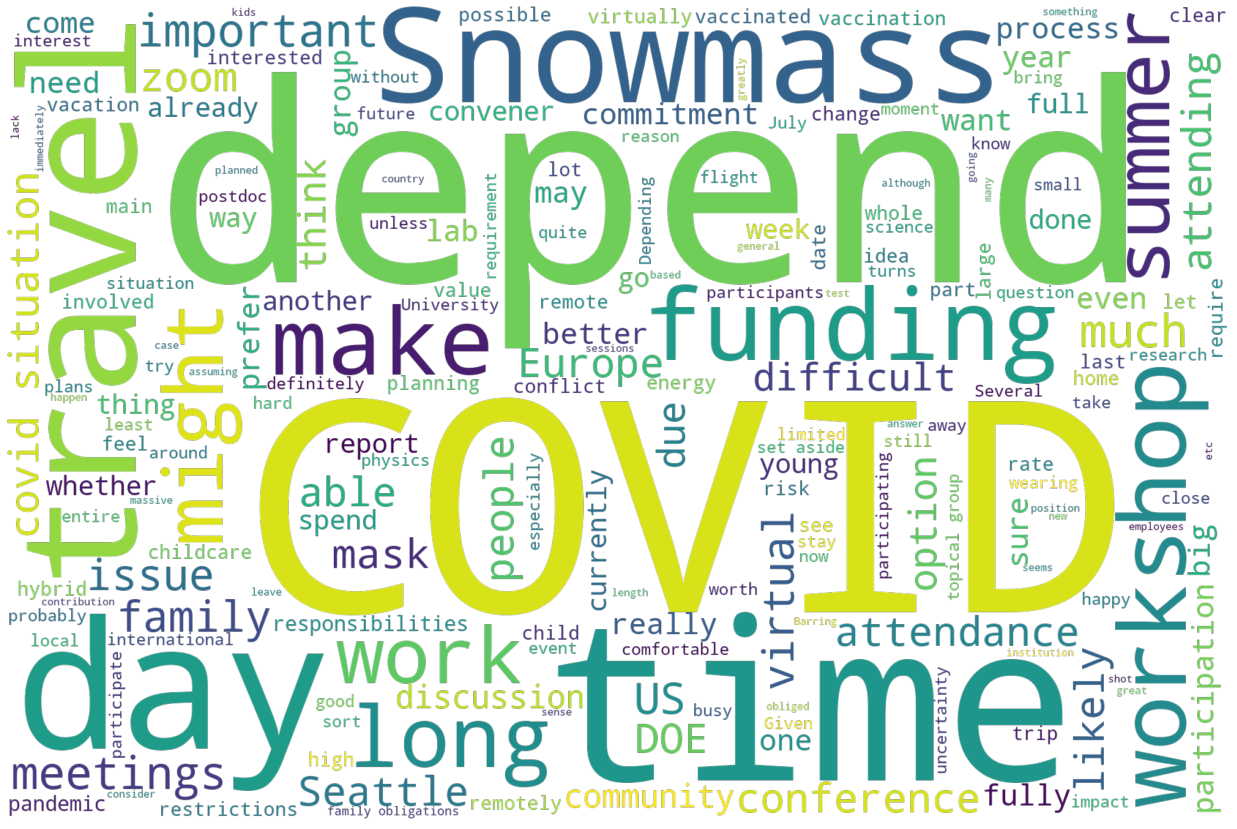

In [5]:
plot_wordcloud(make_wordcloud(survey['attend_feedback'], ['attend', 'person', 'meeting']))

Lets split the data in that word cloud into the three categories to see if we can gain some ideas of what people are thinking about their response. First, here is **would attend**:

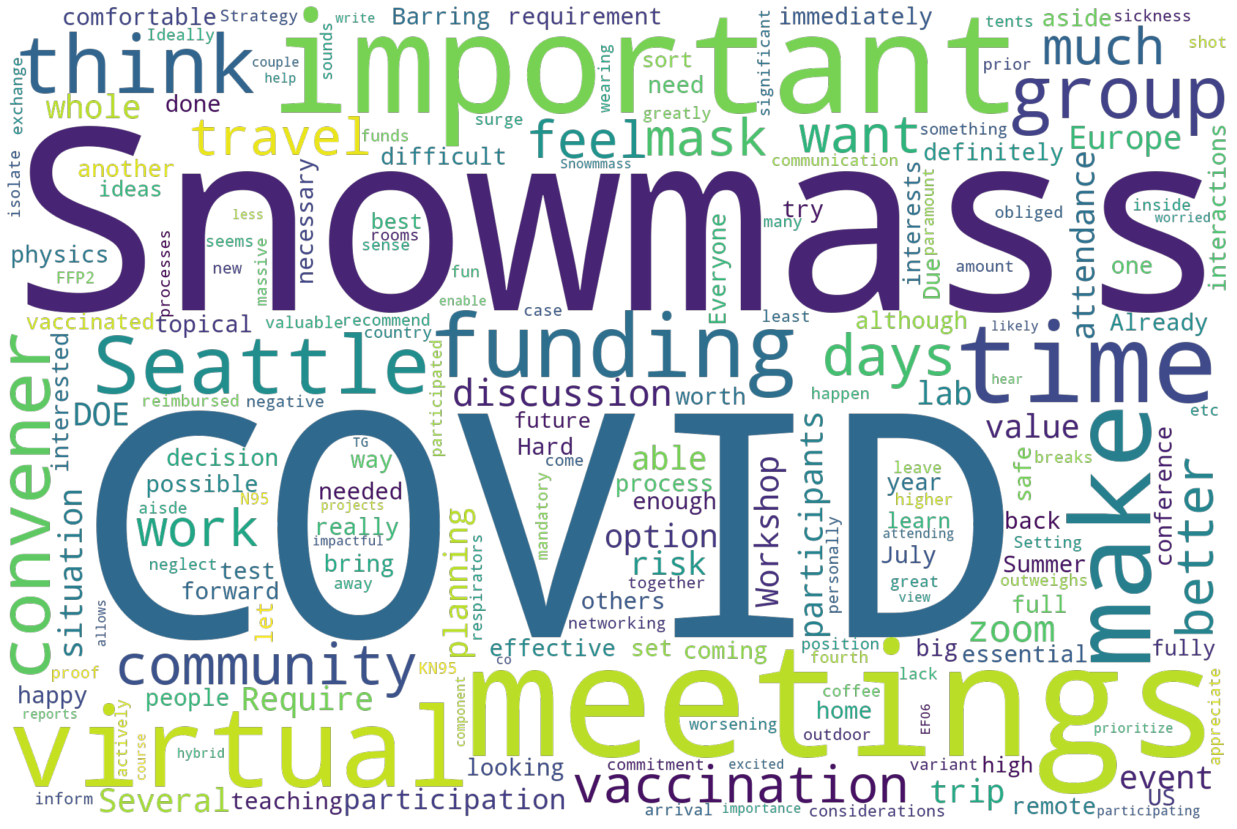

In [6]:
plot_wordcloud(make_wordcloud(survey[survey['attend'] == 'Would attend']['attend_feedback'], ['attend', 'person', 'meeting']))

Next, here is **might attend**:

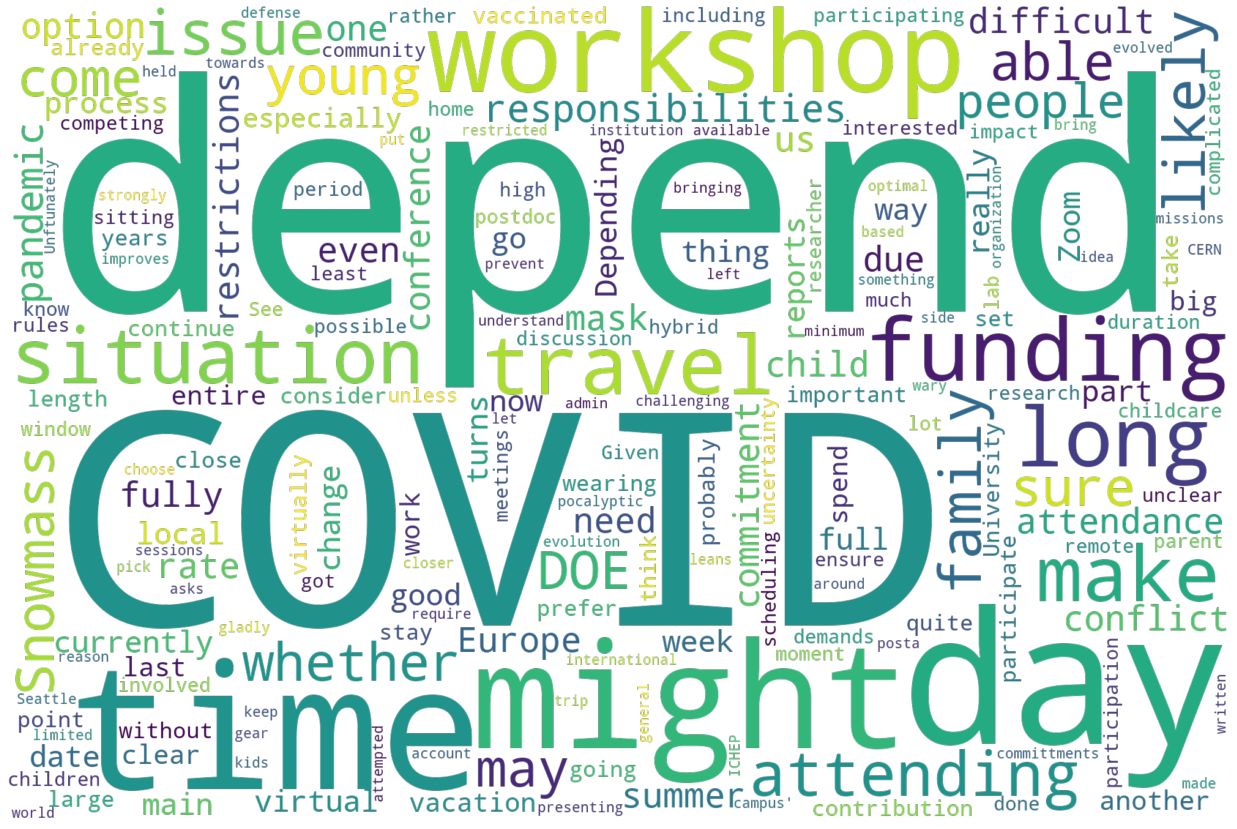

In [7]:
plot_wordcloud(make_wordcloud(survey[survey['attend'] == 'Might attend']['attend_feedback'], ['attend', 'person', 'meeting']))

And finally, here is **would not attend**:

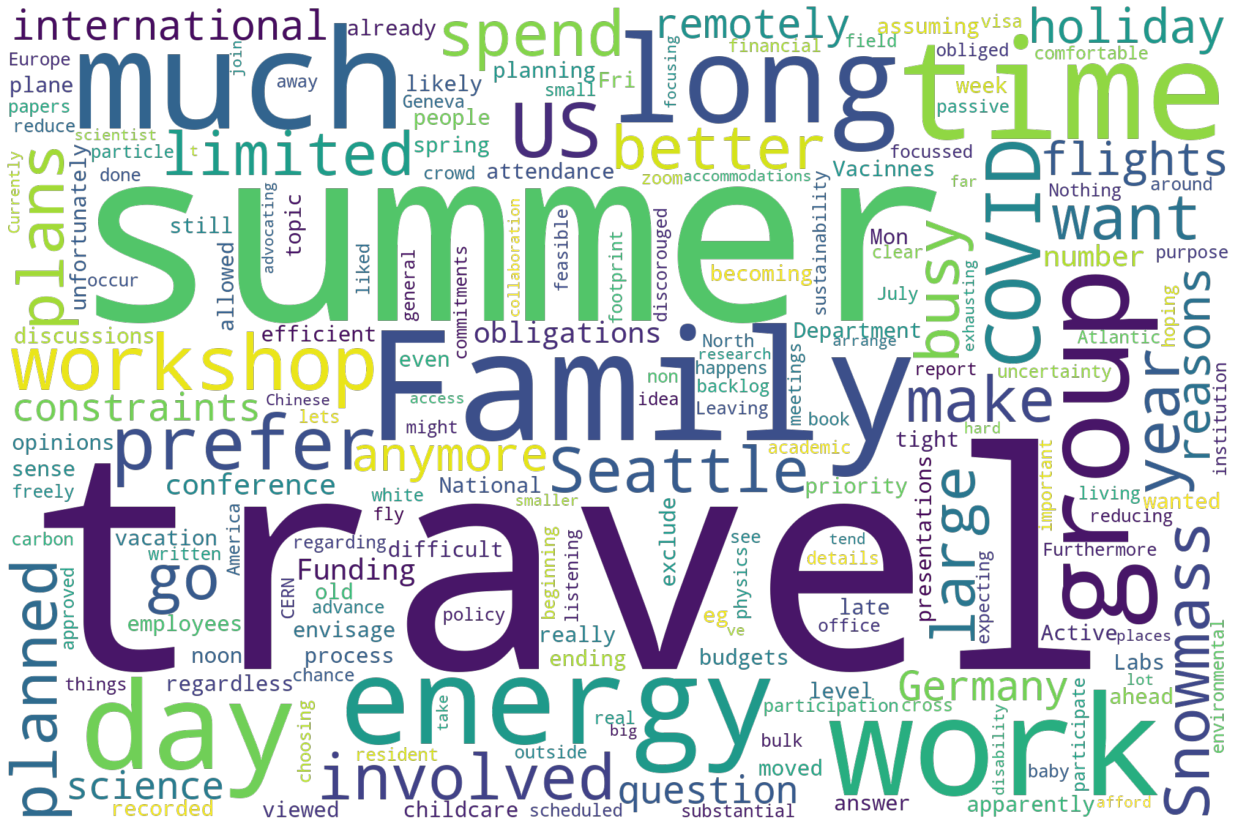

In [8]:
plot_wordcloud(make_wordcloud(survey[survey['attend'] == 'Would not attend']['attend_feedback'], ['attend', 'person', 'meeting']))

Summarizing some of what we see above, and going into the quotes with these words as a guide, it is possible to paraphrase some of the responses (we promised not to transcribe word-for-word the data):

* Would Attend
    * COVID is mentioned a lot - in the sense that the person wants to attend, but COVID would get in the way of it.
    * Funding is mentioned in the same way
    * Great experience at previous Snowmass mentioned, and that we need to do this once in a while for the community.
    * Topical Group Conv - thus it is important for me to attend
    * Most effective work occurs in person
    * DOE will approve this, eventually.
* Might
    * DOE will not allow it
    * Long trip: time, funding, etc.
    * Possible Family Vacation Conflicts
    * What is the point since all topical groups will have their reports done - seems like a very long regular conference.
* Would Not Attend
    * DOE will not allow it
    * Family plans conflict (vacations, etc.)
    * Budgets are very tight for this sort of thing
    * International Travel too far for this
    * Arranging accomodations for disability take too much work/energy
    Cost 


And some suggestions or organization from the text:

* Pre-record presentations, and reserve time for discussion only. Use this as a way to shorten the actual meeting time.

## What Worries You?

First, lets look at what worried people most when they thought about attending. First question - how many people said, basically, they didn't care. That is: nothing worried them on the list:

In [9]:
worried = survey[['worried_covid', 'worried_funding', 'worried_length', 'worried_accessibility', 'worried_responsibilities']].to_numpy()
not_worried = np.sum(np.all(worried >= 4, axis=1))
print(f'Number of people who selected "Not Worried": {not_worried}')

Number of people who selected "Not Worried": 26


The raw data can be simply presented as seperate histograms. The x axis value:

* 1 - Likely will prevent me from attending
* 2 - Might prevent me from attending
* 3 - Could attend, but might limit participation
* 4 - Not a concern
* 5 - Unknown

In [5]:
brush = alt.selection_single(encodings=['y'])
attend = build_attend(selection=brush)

charts = [
    {
        'name': "COVID",
        'col': "worried_covid"
    },
    {
        'name': "Funding",
        'col': "worried_funding"
    },
    {
        'name': "Length",
        'col': "worried_length"
    },
    {
        'name': "Accessability",
        'col': "worried_accessibility"
    },
    {
        'name': "Responsibilities",
        'col': "worried_responsibilities"
    },
]

c_list = [
    (alt.Chart(data=survey, title=c_info['name'])
    .transform_filter(brush)
    .mark_bar()
    .encode(
        x=alt.X(shorthand=f"{c_info['col']}:N", title="", axis=alt.Axis()),
        y=alt.Y(shorthand="count()",title="Number of people", scale=alt.Scale(domain=(0, 650))),
        tooltip=alt.Tooltip("count():N"),
    )
    )
    for c_info in charts
]

c = None
for p in c_list:
    if c is None:
        c = p
    else:
        c = c | p

attend & c

alt.VConcatChart(...)

Selecting the "Would you attend?" histograms will select the data to view in the below plots. A few things:

* Of those that have said they would not attend, 50% of them have a responsibility conflict
* 10% of the might column are worried the length will prevent them from attending
* 15 are worried that accessability will prevent them from attending. Of those 8 indicated they might or would attend if they could. 

Trying to figure out what people are most worried about from this data took some effort. I suppose there are lots of algorithms.

* If people marked everything as "Not Worried" then their entry was ignored for an entry into the histogram.
* Whatever number they used to mark as the highest level of conern added one to the below histogram.

Note this is a relative answer - if someone said nothing was a concern, and marked one item as "might impact my ability to participate", then that will show up in this histogram with the same weight as if someone had marked something "Likely will prevent me from attending".

In [11]:
# We meed top use the numpy argsort to do this: pandas doesn't really work accross columns like this.
worried_argsort = worried.argsort()
worried_desc = [
    'COVID',
    'Funding',
    'Workshop Length',
    'Accessibility',
    'Other Responsibilities'
]

most_worried_list = []
most_worried = worried_argsort[:1]
worried_sort = np.copy(worried)
worried_sort.sort(axis=1)

for idx in range(5):
    mask = worried_sort[:,0] == worried_sort[:, idx]
    worried_idx_list = worried_argsort[mask, idx]
    worried_idx_sort_list = worried_sort[mask, idx]
    do_not_worry = worried_idx_sort_list < 4
    most_worried_list += list(worried_idx_list[do_not_worry])

most_worried = [worried_desc[i] for i in most_worried_list]

(alt.Chart(data=pd.DataFrame(most_worried, columns=['worried']), title="Most Worried About Attending")
    .mark_bar()
    .encode(
        y=alt.Y(shorthand="worried", sort='-x', title=""),
        x=alt.X(shorthand="count()",title="Number of people"),
        tooltip=alt.Tooltip("count():N"),
    )
)

alt.Chart(...)

Next, lets ask a slightly different question. What would impact people's ability to attend? This is basically asking for an entry in the histogram for everyone that marked either "Likely will prevent me from attending" or "Might prevent me from attending".

In [12]:
most_worried_list = []
most_worried = worried_argsort[:1]
worried_sort = np.copy(worried)
worried_sort.sort(axis=1)

for idx in range(5):
    mask = worried_sort[:,0] == worried_sort[:, idx]
    worried_idx_list = worried_argsort[mask, idx]
    worried_idx_sort_list = worried_sort[mask, idx]
    do_not_worry = worried_idx_sort_list < 3
    most_worried_list += list(worried_idx_list[do_not_worry])

most_worried = [worried_desc[i] for i in most_worried_list]

(alt.Chart(data=pd.DataFrame(most_worried, columns=['worried']), title="Would or likely would prevent attending")
    .mark_bar()
    .encode(
        y=alt.Y(shorthand="worried", sort='-x', title=""),
        x=alt.X(shorthand="count()",title="Number of people"),
        tooltip=alt.Tooltip("count():N"),
    )
)

alt.Chart(...)

From these plots:

* COVID is the main worry. Not a surpise!
* Other responsibilities, or considering this not a high enough priority is the next level.
* Looking at the difference between the two plots the workshop length is the only bar that seems to chang fraction by any real amount. That indicates that people are likely nervous the workshop is too long or they will only be able to partially attend the workshop.
* 15 people listed accessibility as a reason they will likley not be able to attend.

### Other Ideas

We also asked an open ended question - what concerns have we forgotten. Here is the wordcloud and a quick scan of the answers:

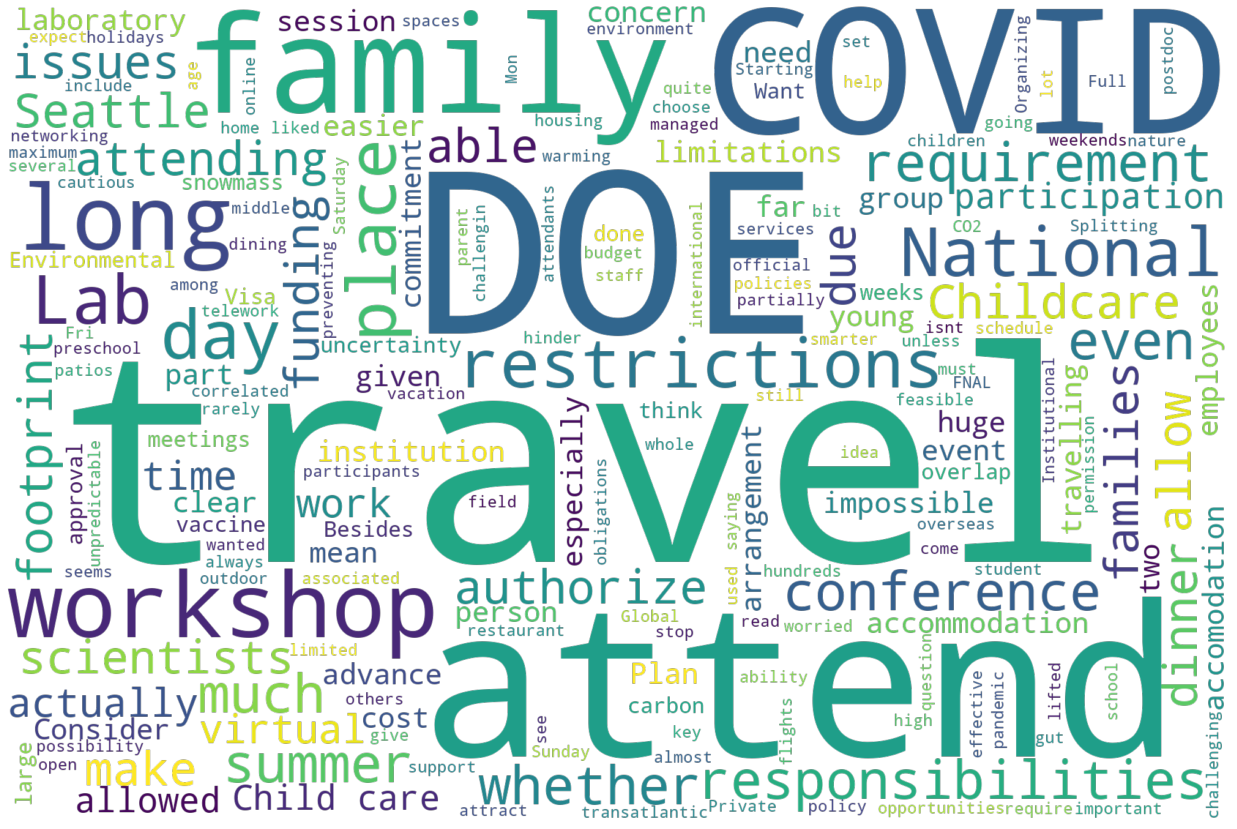

In [13]:
plot_wordcloud(make_wordcloud(survey['attend_other_concerns'], ['issue', 'meeting', 'people', 'may']))

Using those common words as a key to scan the answers, some paraphrased answers:

* Lots of comments on travel: international rescritions, DOE policy, 
* Do not have a large banquet, split into smaller restaurant patios
* If this is not big enough, will it allow for networking
* Childcare
* Carbon Footprint of the travel
* Length - how is it that we can't do this in 3 days?

## Dinner?

Curical for planning, but likely not much else, is dinner.

In [14]:
brush = alt.selection_single(encodings=['y'])

attend = build_attend(selection=brush)

chart_d = (alt.Chart(data=survey, title="Dinner?")
    .transform_filter(brush)
    .transform_joinaggregate(total='count(*)')
    .transform_calculate(pct='1 / datum.total')
    .mark_bar()
    .encode(
        y=alt.Y(shorthand="dinner:N", sort='-x', title=""),
        x=alt.X(shorthand="count()",title="Number of people"),
        tooltip=alt.Tooltip("sum(pct):N", format=".0%"),
        color=default_color
    )
)

chart_d_text = (
    chart_d.mark_text(align="right", dx=-3)
           .encode(
               text=alt.Text("sum(pct):N", format=".0%"),
               color=alt.value("white")
           )

)

attend & (chart_d + chart_d_text)

alt.VConcatChart(...)

The most interesting thing here is that for people that are coming, nearly 80% want to attend the dinner.